In [1]:
import pandas as pd

df = pd.read_csv("data.csv")
df.columns = df.columns.str.strip().str.lower()

In [2]:
top5 = df['disease'].value_counts().head(5).index
top5

Index(['Malaria', 'Dengue', 'Measles', 'Influenza', 'RSV'], dtype='object', name='disease')

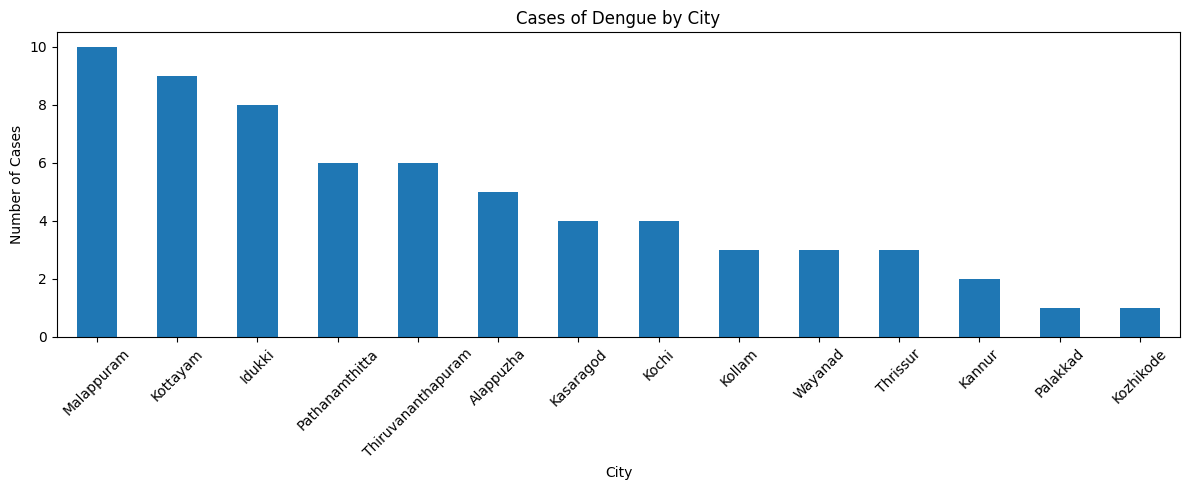

In [3]:
import matplotlib.pyplot as plt

selected_disease = "Dengue"

city_counts = df[df['disease'] == selected_disease]['city'].value_counts()

plt.figure(figsize=(12,5))
city_counts.plot(kind='bar')
plt.title(f"Cases of {selected_disease} by City")
plt.xlabel("City")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


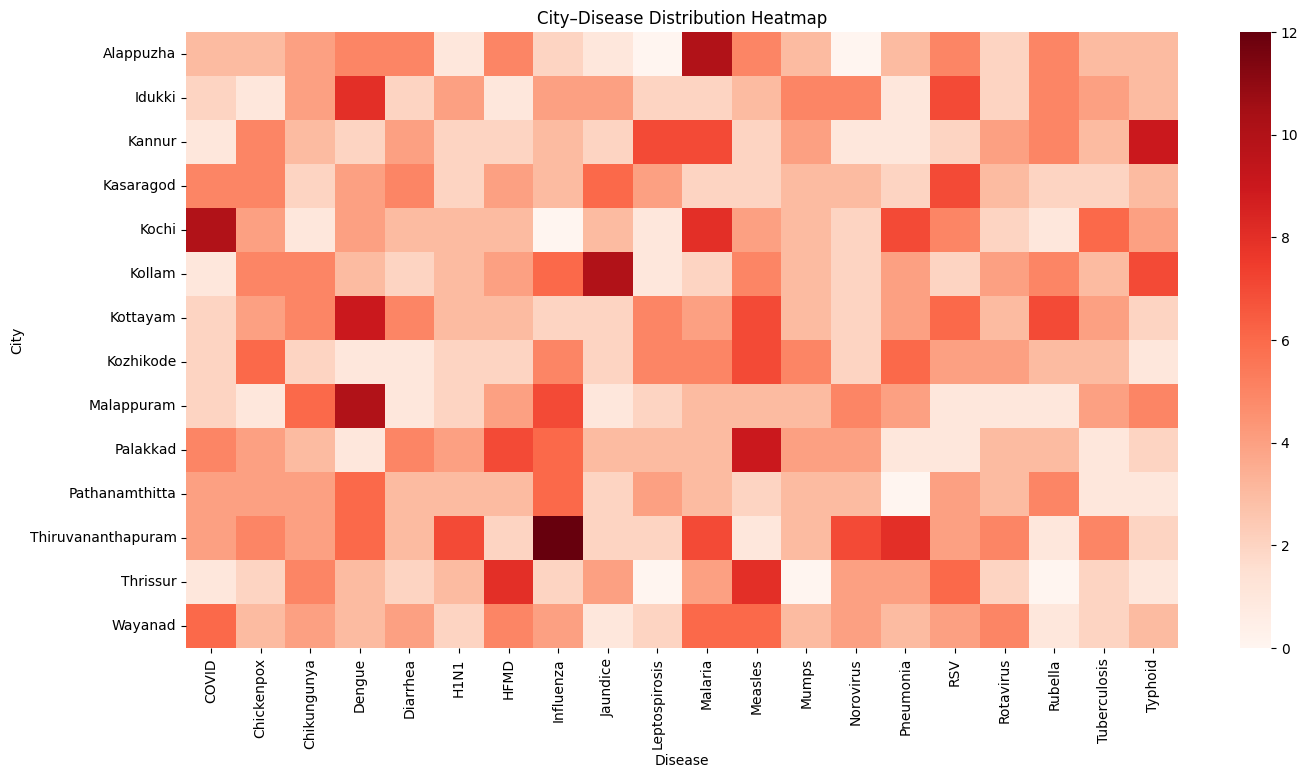

In [4]:
import seaborn as sns

pivot = pd.pivot_table(df, index='city', columns='disease', values='age', aggfunc='count').fillna(0)

plt.figure(figsize=(16,8))
sns.heatmap(pivot, cmap='Reds')
plt.title("City–Disease Distribution Heatmap")
plt.xlabel("Disease")
plt.ylabel("City")
plt.show()


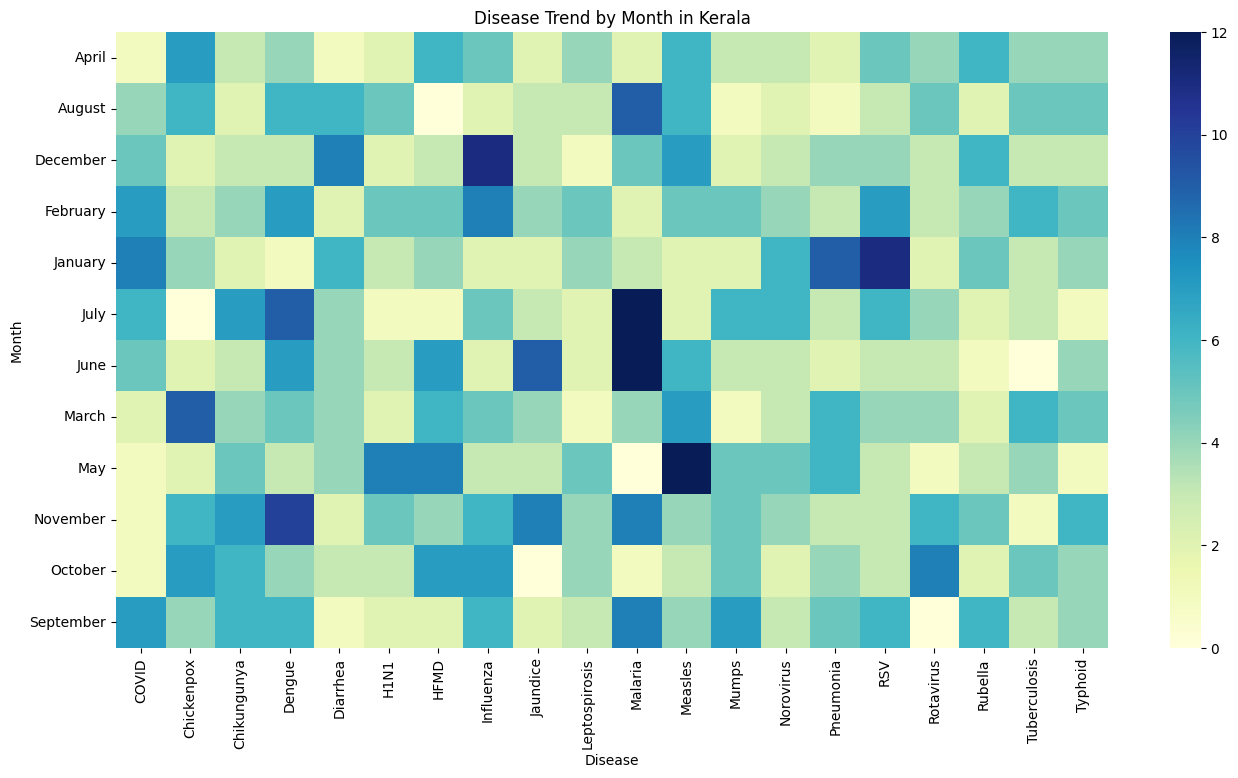

In [5]:
pivot2 = pd.pivot_table(df, index='month', columns='disease', values='age', aggfunc='count').fillna(0)

plt.figure(figsize=(16,8))
sns.heatmap(pivot2, cmap='YlGnBu')
plt.title("Disease Trend by Month in Kerala")
plt.xlabel("Disease")
plt.ylabel("Month")
plt.show()


In [6]:
!pip install geopandas folium

In [7]:
import pandas as pd
import geopandas as gpd
import folium

# ---------------------------
# STEP 1 — LOAD DATASET
# ---------------------------
from google.colab import files
uploaded = files.upload()   # upload diseasedata.csv

df = pd.read_csv(list(uploaded.keys())[0])
df.columns = df.columns.str.lower().str.strip()

# ---------------------------
# STEP 2 — CITY → DISTRICT MAP
# ---------------------------
city_to_district = {
    "kochi": "ernakulam",
    "ernakulam": "ernakulam",
    "thrissur": "thrissur",
    "malappuram": "malappuram",
    "kollam": "kollam",
    "kozhikode": "kozhikode",
    "kannur": "kannur",
    "thiruvananthapuram": "thiruvananthapuram",
    "trivandrum": "thiruvananthapuram",
    "alappuzha": "alappuzha",
    "palakkad": "palakkad",
    "idukki": "idukki",
    "pathanamthitta": "pathanamthitta",
    "wayanad": "wayanad",
    "kasargod": "kasaragod",
    "kasaragod": "kasaragod",
    "kottayam": "kottayam"
}

df["city"] = df["city"].str.lower().str.strip()
df["district"] = df["city"].map(city_to_district)

# ---------------------------
# STEP 3 — LOAD KERALA MAP
# ---------------------------
# 🔻 PASTE your working GeoJSON link between quotes
shapefile_url = "https://cdn.jsdelivr.net/gh/udit-001/india-maps-data@8d907bc/geojson/states/kerala.geojson"
kerala_geo = gpd.read_file(shapefile_url)

kerala_geo["district"] = kerala_geo["district"].str.lower().str.strip()

# ---------------------------
# STEP 4 — FIND TOP 5 DISEASES
# ---------------------------
top5 = df["disease"].value_counts().head(5).index.tolist()
print("Top 5 diseases:", top5)

# ---------------------------
# STEP 5 — MAP INITIALIZATION
# ---------------------------
m = folium.Map(location=[10.3, 76.3], zoom_start=7)

# ---------------------------
# STEP 6 — ADD TOGGLE LAYERS
# ---------------------------
for disease in top5:
    layer = folium.FeatureGroup(name=disease, show=False)
    subset = df[df["disease"] == disease]

    for _, row in subset.dropna(subset=["district"]).iterrows():
        match = kerala_geo[kerala_geo["district"] == row["district"]]
        if not match.empty:
            centroid = match.geometry.centroid.iloc[0]
            popup_text = f"Disease: {disease}<br>District: {row['district'].title()}<br>Month: {row['month']}"
            folium.CircleMarker(
                location=[centroid.y, centroid.x],
                radius=6,
                color="red",
                fill=True,
                fill_opacity=0.7,
                popup=popup_text
            ).add_to(layer)

    layer.add_to(m)

folium.LayerControl().add_to(m)

# ---------------------------
# STEP 7 — DISPLAY MAP
# ---------------------------
m

Saving data.csv to data (1).csv
Top 5 diseases: ['Malaria', 'Dengue', 'Measles', 'Influenza', 'RSV']


/tmp/ipython-input-2066822424.py:70: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = match.geometry.centroid.iloc[0]
/tmp/ipython-input-2066822424.py:70: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = match.geometry.centroid.iloc[0]
/tmp/ipython-input-2066822424.py:70: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = match.geometry.centroid.iloc[0]
/tmp/ipython-input-2066822424.py:70: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS b

In [8]:
!pip install xgboost

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("data.csv")   # rename if needed
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# Label encoders for features
le_city = LabelEncoder()
le_month = LabelEncoder()
le_gender = LabelEncoder()
le_location = LabelEncoder()
le_symptom = LabelEncoder()   # NEW

df["city"] = le_city.fit_transform(df["city"])
df["month"] = le_month.fit_transform(df["month"])
df["gender"] = le_gender.fit_transform(df["gender"])
df["location"] = le_location.fit_transform(df["location"])
df["symptom"] = le_symptom.fit_transform(df["symptom"])   # NEW

# Encode target (temporarily for ML)
le_disease = LabelEncoder()
df["disease_encoded"] = le_disease.fit_transform(df["disease"])

# Updated ML features including symptom
X = df[["city", "month", "gender", "age", "location", "symptom"]]   # NEW ✔
y = df["disease_encoded"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.09,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="mlogloss"
)
model.fit(X_train, y_train)

# Predict + accuracy
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 1.0


In [10]:
predicted_label = le_disease.inverse_transform(y_pred)
print(predicted_label[:10])   # first 10 predictions


['Diarrhea' 'Pneumonia' 'Measles' 'Dengue' 'COVID' 'Malaria' 'Jaundice'
 'Norovirus' 'Measles' 'Pneumonia']


In [11]:
sample = pd.DataFrame(
    [[ "Kollam", "May", "M", 35, "Urban", "Yellow eyes and skin" ]],
    columns=["city","month","gender","age","location","symptom"]
)

sample["city"] = le_city.transform(sample["city"])
sample["month"] = le_month.transform(sample["month"])
sample["gender"] = le_gender.transform(sample["gender"])
sample["location"] = le_location.transform(sample["location"])
sample["symptom"] = le_symptom.transform(sample["symptom"])   # NEW

pred = model.predict(sample)
decoded = le_disease.inverse_transform(pred)
print("Predicted disease:", decoded[0])


Predicted disease: Jaundice


In [12]:
from scipy.stats import chi2_contingency
import pandas as pd

# all categorical predictors you want to evaluate
categorical_cols = ["city", "month", "gender", "location", "symptom"]

for col in categorical_cols:
    table = pd.crosstab(df[col], df["disease"])  # contingency table
    stat, p, dof, expected = chi2_contingency(table)

    significance = "Significant" if p < 0.05 else "Not Significant"
    print(f"{col} → p-value: {p:.6f} → {significance}")


city → p-value: 0.014610 → Significant
month → p-value: 0.001064 → Significant
gender → p-value: 0.276812 → Not Significant
location → p-value: 0.566223 → Not Significant
symptom → p-value: 0.000000 → Significant


In [13]:
chi_scores = {}
categorical_cols = ["city", "month", "gender", "location", "symptom"]

for col in categorical_cols:
    table = pd.crosstab(df[col], df["disease"])
    _, p, _, _ = chi2_contingency(table)
    chi_scores[col] = p

sorted_scores = dict(sorted(chi_scores.items(), key=lambda x: x[1]))
print("\nVariables ranked by strength:")
for col, score in sorted_scores.items():
    print(f"{col} → p-value: {score:.6f}")



Variables ranked by strength:
symptom → p-value: 0.000000
month → p-value: 0.001064
city → p-value: 0.014610
gender → p-value: 0.276812
location → p-value: 0.566223


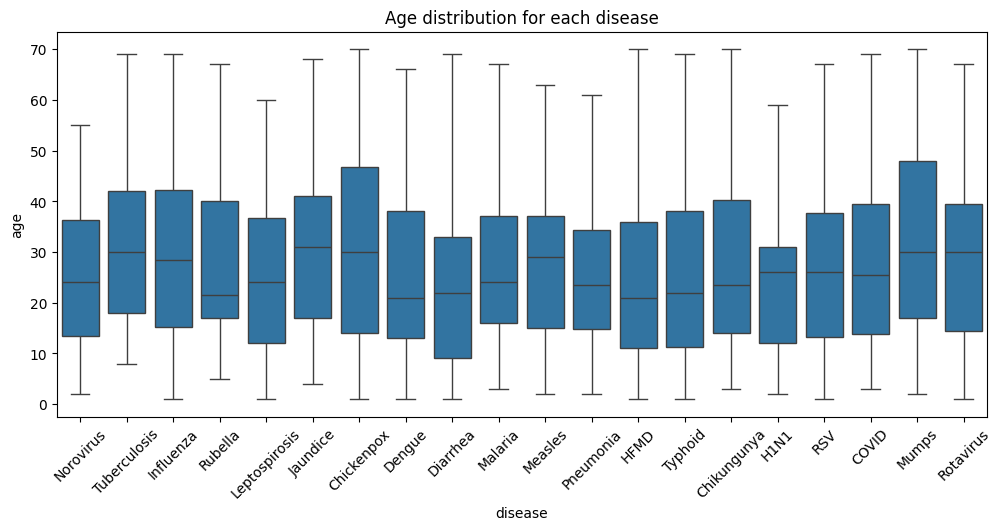

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.boxplot(x="disease", y="age", data=df)
plt.xticks(rotation=45)
plt.title("Age distribution for each disease")
plt.show()

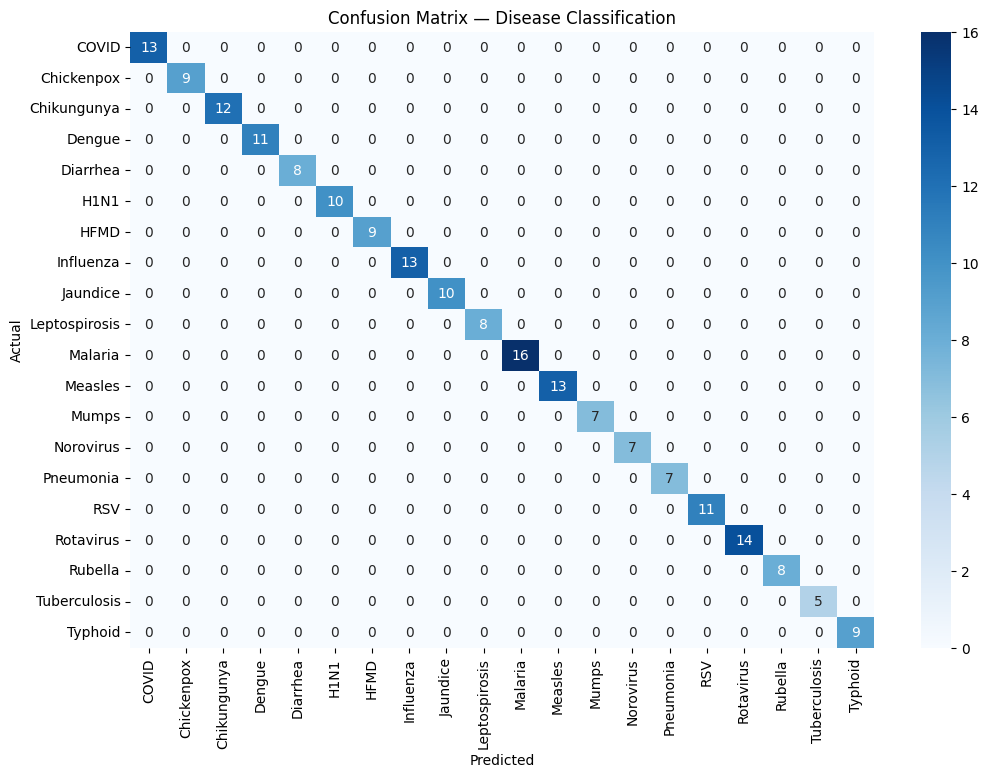


Classification Report:

               precision    recall  f1-score   support

        COVID       1.00      1.00      1.00        13
   Chickenpox       1.00      1.00      1.00         9
  Chikungunya       1.00      1.00      1.00        12
       Dengue       1.00      1.00      1.00        11
     Diarrhea       1.00      1.00      1.00         8
         H1N1       1.00      1.00      1.00        10
         HFMD       1.00      1.00      1.00         9
    Influenza       1.00      1.00      1.00        13
     Jaundice       1.00      1.00      1.00        10
Leptospirosis       1.00      1.00      1.00         8
      Malaria       1.00      1.00      1.00        16
      Measles       1.00      1.00      1.00        13
        Mumps       1.00      1.00      1.00         7
    Norovirus       1.00      1.00      1.00         7
    Pneumonia       1.00      1.00      1.00         7
          RSV       1.00      1.00      1.00        11
    Rotavirus       1.00      1.00     

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=test_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le_disease.inverse_transform(test_labels),
    yticklabels=le_disease.inverse_transform(test_labels)
)
plt.title("Confusion Matrix — Disease Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred,
    labels=test_labels,
    target_names=le_disease.inverse_transform(test_labels)
))
